# Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.metrics import (confusion_matrix, matthews_corrcoef,
                             precision_score, recall_score)

# Funções Helpers

## Cálculo da média de cada métrica

In [39]:
def averages(values):
    values['image'].append('media_total')
    recall_average = np.average(values['recall'])
    values['recall'].append(recall_average)
    precision_average = np.average(values['precision'])
    values['precision'].append(precision_average)
    mcc_average = np.average(values['mcc'])
    values['mcc'].append(mcc_average)
    speci_average = np.average(values['specificity'])
    values['specificity'].append(speci_average)
    
    return values

## Calcula métricas de uma imagem

In [40]:
def update_values(values, file, ouro, image):
    values['image'].append(str(file))
    values['recall'].append(recall_score(ouro, image))
    values['precision'].append(precision_score(ouro, image))
    values['mcc'].append(matthews_corrcoef(ouro, image))
    
    tn, fp, fn, tp = confusion_matrix(ouro, image).ravel()
    values['specificity'].append(tn / (tn+fp))
    
    return values

# Paths que serão utilizados

In [4]:
paths_names = [
                'tests/adap_original', 'tests/adap_original_pos_processado',
                'tests/segme_original', 'tests/otsu_original',
                'tests/LAB_l_thresh_otsu', 'tests/LAB_l_thresh_adap',
                'tests/LAB_l_thresh_adap_new', 'tests/LAB_thresh_otsu',
                'tests/LAB_thresh_adap', 'tests/RGB_g_thresh',
                'tests/RGB_g_thresh_adap', 'tests/RGB_g_thresh_pos_processamento',
                'tests/YCRCB_thresh_adap', 'tests/YCRCB_thresh_otsu',
                'tests/YCRCB_y_thresh_adap', 'tests/YCRCB_y_thresh_otsu'
              ]

# Cálculo de métricas para todas as imagens geras

In [5]:
for path_name in paths_names:
    path = Path(path_name)
    print('-------- {} --------'.format(path))
    
    files = [file for file in path.iterdir() if file.is_file() and '_' not in file.name]
    files = sorted(files)
    
    values = {
        'image': [],
        'recall': [],
        'precision': [],
        'mcc': [],
        'specificity': []
    }
    
    for file in files:
        file_ = str(file)
        print(file_)

        path_ouro = file_.replace(path_name, 'database/gold')
        
        image = cv2.imread(file_, 0)
        ouro = cv2.imread(path_ouro, 0)

        _, image_ = cv2.threshold(image,0,255,
                                  cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        _, ouro = cv2.threshold(ouro,0,255,
                                cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        image_ = image_.reshape(-1)
        image_ = np.where(image_ == 255, 1, image_)
        ouro = ouro.reshape(-1)
        ouro = np.where(ouro == 255, 1, ouro)
        
        values = update_values(values, file, ouro, image_)
        print('## Update values ##')

    values = averages(values)
    df = pd.DataFrame.from_dict(values)
    
    folder = str(path).split('/')[1]
    df.to_json('metricas/{}.json'.format(folder))

-------- tests/YCRCB_thresh_adap --------
tests/YCRCB_thresh_adap/11.jpg
## Update values ##
tests/YCRCB_thresh_adap/12.jpg
## Update values ##
tests/YCRCB_thresh_adap/13.jpg
## Update values ##
tests/YCRCB_thresh_adap/14.jpg
## Update values ##
tests/YCRCB_thresh_adap/15.jpg


/home/mufasa/.cache/pypoetry/virtualenvs/image-processing-chromosomes-py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mufasa/.cache/pypoetry/virtualenvs/image-processing-chromosomes-py3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## Update values ##
tests/YCRCB_thresh_adap/16.jpg
## Update values ##
tests/YCRCB_thresh_adap/17.jpg
## Update values ##
tests/YCRCB_thresh_adap/18.jpg
## Update values ##
tests/YCRCB_thresh_adap/19.jpg
## Update values ##
tests/YCRCB_thresh_adap/20.jpg
## Update values ##
tests/YCRCB_thresh_adap/21.jpg
## Update values ##
tests/YCRCB_thresh_adap/22.jpg
## Update values ##
tests/YCRCB_thresh_adap/23.jpg
## Update values ##
tests/YCRCB_thresh_adap/24.jpg
## Update values ##
tests/YCRCB_thresh_adap/25.jpg
## Update values ##
tests/YCRCB_thresh_adap/26.jpg
## Update values ##
tests/YCRCB_thresh_adap/27.jpg
## Update values ##
tests/YCRCB_thresh_adap/28.jpg
## Update values ##
tests/YCRCB_thresh_adap/29.jpg
## Update values ##
tests/YCRCB_thresh_adap/30.jpg
## Update values ##
tests/YCRCB_thresh_adap/31.jpg
## Update values ##
tests/YCRCB_thresh_adap/32.jpg
## Update values ##
tests/YCRCB_thresh_adap/33.jpg
## Update values ##
tests/YCRCB_thresh_adap/34.jpg
## Update values ##
tests/YCRCB

## Update values ##
tests/YCRCB_thresh_otsu/80.jpg
## Update values ##
tests/YCRCB_thresh_otsu/81.jpg
## Update values ##
tests/YCRCB_thresh_otsu/82.jpg
## Update values ##
tests/YCRCB_thresh_otsu/83.jpg
## Update values ##
tests/YCRCB_thresh_otsu/84.jpg
## Update values ##
tests/YCRCB_thresh_otsu/85.jpg
## Update values ##
tests/YCRCB_thresh_otsu/86.jpg
## Update values ##
tests/YCRCB_thresh_otsu/87.jpg
## Update values ##
tests/YCRCB_thresh_otsu/88.jpg
## Update values ##
tests/YCRCB_thresh_otsu/89.jpg
## Update values ##
tests/YCRCB_thresh_otsu/9.jpg
## Update values ##
tests/YCRCB_thresh_otsu/90.jpg
## Update values ##
tests/YCRCB_thresh_otsu/91.jpg
## Update values ##
tests/YCRCB_thresh_otsu/92.jpg
## Update values ##
tests/YCRCB_thresh_otsu/93.jpg
## Update values ##
tests/YCRCB_thresh_otsu/94.jpg
## Update values ##
tests/YCRCB_thresh_otsu/95.jpg
## Update values ##
tests/YCRCB_thresh_otsu/96.jpg
## Update values ##
tests/YCRCB_thresh_otsu/97.jpg
## Update values ##
tests/YCRCB_

## Update values ##
tests/YCRCB_y_thresh_otsu/50.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/51.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/52.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/53.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/54.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/55.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/56.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/57.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/58.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/59.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/6.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/60.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/61.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/62.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/63.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/64.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/65.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/66.jpg
## Update values ##
tests/YCRCB_y_thresh_otsu/6

# Extrai médias totais

In [13]:
paths_names = [
                'tests/adap_original', 'tests/adap_original_pos_processado',
                'tests/segme_original', 'tests/otsu_original',
                'tests/LAB_l_thresh_otsu', 'tests/LAB_l_thresh_adap',
                'tests/LAB_l_thresh_adap_new', 'tests/LAB_thresh_otsu',
                'tests/LAB_thresh_adap', 'tests/RGB_g_thresh',
                'tests/RGB_g_thresh_adap', 'tests/RGB_g_thresh_pos_processamento',
                'tests/YCRCB_thresh_adap', 'tests/YCRCB_thresh_otsu',
                'tests/YCRCB_y_thresh_adap', 'tests/YCRCB_y_thresh_otsu'
              ]

In [14]:
media_total = {
    'image': [],
    'recall': [],
    'precision': [],
    'mcc': [],
    'specificity': []
}

for path_name in paths_names:
    folder = str(path_name).split('/')[1]
    
    df = pd.read_json('metricas/{}.json'.format(folder))
    aux = df[df['image'] == 'media_total']
    
    values = aux.to_dict('list')
    values['image'] = [folder]
    
    for key, date in values.items():
        media_total.setdefault(key, []).append(date[0])


## Salva em um json

In [15]:
df = pd.DataFrame.from_dict(media_total)
df.to_json('metricas/medias_totais.json')

# Geração de gráficos

## Método adaptativo

In [2]:
paths_adap = [
    'adap_original', 'adap_original_pos_processado',
    'LAB_l_thresh_adap', 'LAB_l_thresh_adap_new',
    'LAB_thresh_adap', 'RGB_g_thresh_adap',
    'YCRCB_thresh_adap', 'YCRCB_y_thresh_adap',
]

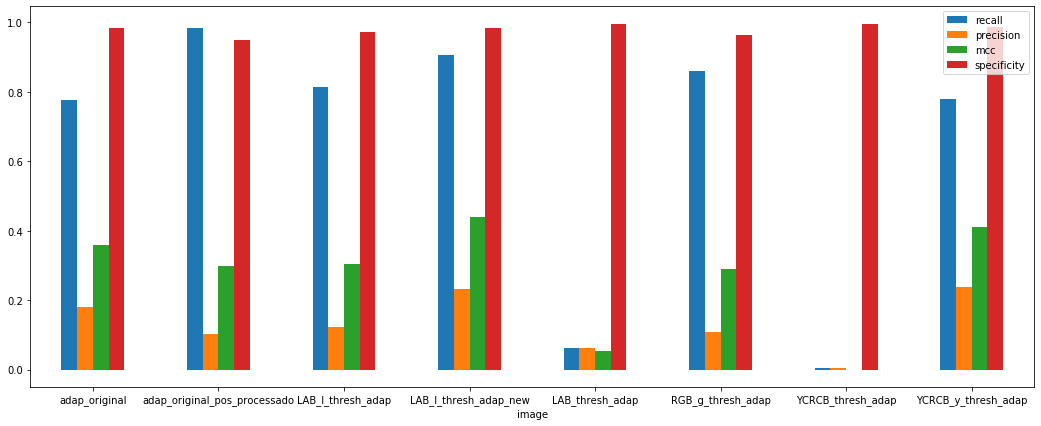

In [24]:
df_adap = df[df['image'].isin(paths_adap)]

ax = df_adap.plot.bar(rot=0, x='image', figsize=(18,7))
# for p in ax.patches:
#     ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

## Método otsu

In [25]:
paths_otsu = [
    'otsu_original',
    'LAB_l_thresh_otsu', 'LAB_thresh_otsu',
    'RGB_g_thresh', 'RGB_g_thresh_pos_processamento',
    'YCRCB_thresh_otsu', 'YCRCB_y_thresh_otsu'
]

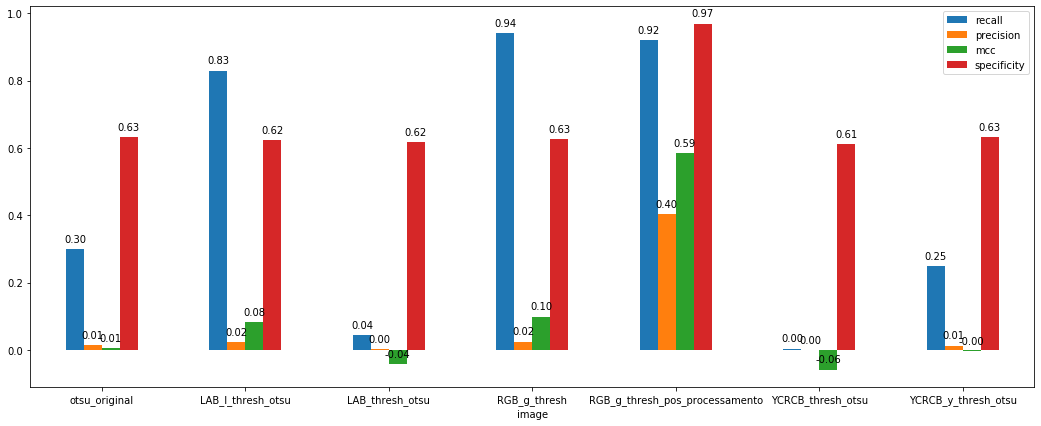

In [43]:
# df = pd.read_json('metricas/medias_totais.json')

df_otsu = df[df['image'].isin(paths_otsu)]

ax = df_otsu.plot.bar(rot=0, x='image', figsize=(18,7))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

## Melhores métodos

In [41]:
paths_bests = [
    'segme_original',
    'RGB_g_thresh_pos_processamento',
    'LAB_l_thresh_adap_new', 'YCRCB_y_thresh_adap',
    'adap_original'
]

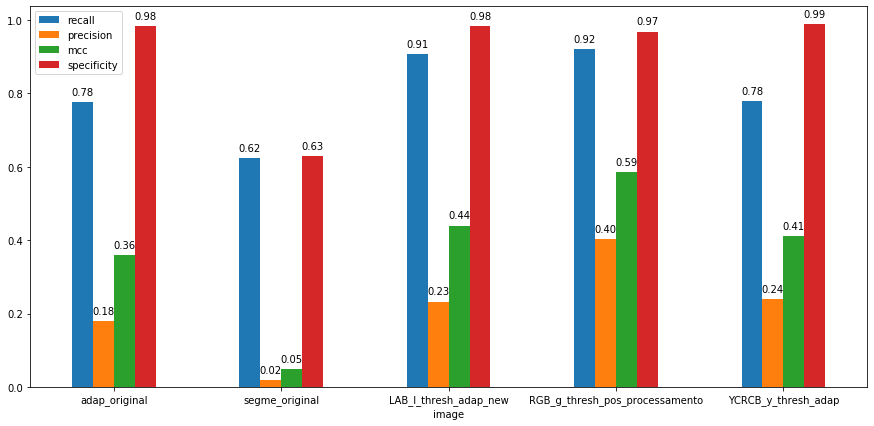

In [42]:
df_best = df[df['image'].isin(paths_bests)]

ax = df_best.plot.bar(rot=0, x='image', figsize=(15,7))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')